<a href="https://colab.research.google.com/github/RAvila-bioeng/M.R.AI/blob/gonzalo/alzheimer's_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:

from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle_API"

# Descargar dataset
!kaggle datasets download -d ninadaithal/imagesoasis

# Descomprimir
!unzip -q imagesoasis.zip

import os
print("Contenido del directorio actual:", os.listdir("."))
print("Contenido de 'Data' si existe:", os.listdir("Data") if os.path.exists("Data") else "No existe 'Data'")


Mounted at /content/gdrive
Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): apache-2.0
100% 1.23G/1.23G [00:08<00:00, 259MB/s]
100% 1.23G/1.23G [00:08<00:00, 152MB/s]
Contenido del directorio actual: ['.config', 'imagesoasis.zip', 'Data', 'gdrive', 'sample_data']
Contenido de 'Data' si existe: ['Moderate Dementia', 'Non Demented', 'Mild Dementia', 'Very mild Dementia']


In [3]:
import os
import shutil
import random
from collections import defaultdict

original_dir = "./Data"
assert os.path.exists(original_dir), "No existe ./Data. Revisa la celda 1."

subset_dir = "./Data_subset"

# Empezar *limpio*
if os.path.exists(subset_dir):
    shutil.rmtree(subset_dir)
os.makedirs(subset_dir, exist_ok=True)

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
N_PATIENTS_NON_DEMENTED = 120  # nº máximo de pacientes sanos

classes = [d for d in os.listdir(original_dir)
           if os.path.isdir(os.path.join(original_dir, d))]
print("Clases encontradas en Data:", classes)

for cls in classes:
    src_cls_dir = os.path.join(original_dir, cls)
    dst_cls_dir = os.path.join(subset_dir, cls)
    os.makedirs(dst_cls_dir, exist_ok=True)

    print(f"\nProcesando clase: {cls}")

    if "non" not in cls.lower():   # todas menos Non Demented
        imgs = [f for f in os.listdir(src_cls_dir)
                if f.lower().endswith(valid_exts)]
        print(f"  Copiando TODAS las imágenes ({len(imgs)})...")
        for fname in imgs:
            shutil.copy2(os.path.join(src_cls_dir, fname),
                         os.path.join(dst_cls_dir, fname))

    else:
        # Non Demented: reducir por nº de pacientes
        imgs = [f for f in os.listdir(src_cls_dir)
                if f.lower().endswith(valid_exts)]
        print(f"  Imágenes totales en {cls}: {len(imgs)}")
        print("  Ejemplos de nombres:", imgs[:5])

        images_by_patient = defaultdict(list)
        for fname in imgs:
            parts = fname.split('_')
            # OAS1_0097_MR1_mpr-3_127.jpg → paciente = "OAS1_0097"
            patient_id = "_".join(parts[:2]) if len(parts) >= 2 else parts[0]
            images_by_patient[patient_id].append(fname)

        print(f"  Pacientes totales detectados: {len(images_by_patient)}")

        patients = list(images_by_patient.keys())
        n_keep = min(N_PATIENTS_NON_DEMENTED, len(patients))
        selected_patients = random.sample(patients, n_keep)

        print(f"  Pacientes que vamos a conservar en {cls}: {n_keep}")

        count_imgs = 0
        for pid in selected_patients:
            for fname in images_by_patient[pid]:
                shutil.copy2(os.path.join(src_cls_dir, fname),
                             os.path.join(dst_cls_dir, fname))
                count_imgs += 1

        print(f"  Imágenes copiadas en {cls} (subset): {count_imgs}")

print("\n✅ Data_subset creado en:", subset_dir)

# Comprobar conteos
for cls in os.listdir(subset_dir):
    cls_path = os.path.join(subset_dir, cls)
    if os.path.isdir(cls_path):
        n = len([f for f in os.listdir(cls_path)
                 if f.lower().endswith(valid_exts)])
        print(f"{cls}: {n} imágenes en Data_subset")


Clases encontradas en Data: ['Moderate Dementia', 'Non Demented', 'Mild Dementia', 'Very mild Dementia']

Procesando clase: Moderate Dementia
  Copiando TODAS las imágenes (488)...

Procesando clase: Non Demented
  Imágenes totales en Non Demented: 67222
  Ejemplos de nombres: ['OAS1_0076_MR1_mpr-1_114.jpg', 'OAS1_0368_MR2_mpr-4_135.jpg', 'OAS1_0348_MR1_mpr-3_130.jpg', 'OAS1_0001_MR1_mpr-2_140.jpg', 'OAS1_0145_MR2_mpr-1_111.jpg']
  Pacientes totales detectados: 266
  Pacientes que vamos a conservar en Non Demented: 120
  Imágenes copiadas en Non Demented (subset): 30256

Procesando clase: Mild Dementia
  Copiando TODAS las imágenes (5002)...

Procesando clase: Very mild Dementia
  Copiando TODAS las imágenes (13725)...

✅ Data_subset creado en: ./Data_subset
Moderate Dementia: 488 imágenes en Data_subset
Non Demented: 30256 imágenes en Data_subset
Mild Dementia: 5002 imágenes en Data_subset
Very mild Dementia: 13725 imágenes en Data_subset


In [4]:
import os
import shutil
import random
from collections import defaultdict

subset_dir = "./Data_subset"          # de aquí leemos
split_root = "./Data_split_3cls"      # aquí escribimos el nuevo split

# Limpiar split anterior (si existe)
if os.path.exists(split_root):
    shutil.rmtree(split_root)
os.makedirs(split_root, exist_ok=True)

splits = ["train", "val", "test"]
for s in splits:
    os.makedirs(os.path.join(split_root, s), exist_ok=True)

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

# Mapeo de clases físicas -> clases lógicas
# Moderate Dementia se fusiona con Mild Dementia
CLASS_MAP = {
    "Non Demented": "Non Demented",
    "Very mild Dementia": "Very mild Dementia",
    "Mild Dementia": "Mild Dementia",
    "Moderate Dementia": "Mild Dementia",
}

# 1) Construimos un diccionario: logical_class -> patient_id -> lista de rutas de imagen
class_patient_images = defaultdict(lambda: defaultdict(list))

physical_classes = [d for d in os.listdir(subset_dir)
                    if os.path.isdir(os.path.join(subset_dir, d))]
print("Clases físicas en subset:", physical_classes)

for phys_cls in physical_classes:
    if phys_cls not in CLASS_MAP:
        print(f"  Aviso: clase {phys_cls} no está en CLASS_MAP, se ignora.")
        continue

    logical_cls = CLASS_MAP[phys_cls]
    cls_dir = os.path.join(subset_dir, phys_cls)

    print(f"\nLeyendo clase física '{phys_cls}' como clase lógica '{logical_cls}'")

    for fname in os.listdir(cls_dir):
        if not fname.lower().endswith(valid_exts):
            continue

        # Sacar patient_id de nombres tipo: OAS1_0028_MR1_mpr-1_100.jpg
        parts = fname.split('_')
        patient_id = "_".join(parts[:2]) if len(parts) >= 2 else parts[0]

        full_path = os.path.join(cls_dir, fname)
        class_patient_images[logical_cls][patient_id].append(full_path)

# 2) Hacemos el split por paciente para cada clase lógica
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

for logical_cls, patients_dict in class_patient_images.items():
    print(f"\n=== Splitting logical class: {logical_cls} ===")

    patient_ids = list(patients_dict.keys())
    random.shuffle(patient_ids)
    n_total = len(patient_ids)

    # nº de pacientes por split
    n_train = max(1, int(TRAIN_RATIO * n_total))
    n_val = max(1, int(VAL_RATIO * n_total))
    n_test = n_total - n_train - n_val
    if n_test <= 0:
        n_test = 1
        n_train = max(1, n_train - 1)

    train_patients = patient_ids[:n_train]
    val_patients = patient_ids[n_train:n_train + n_val]
    test_patients = patient_ids[n_train + n_val:]

    print(f"  Pacientes: total={n_total}, train={len(train_patients)}, val={len(val_patients)}, test={len(test_patients)}")

    # Crear carpetas de clase lógica en cada split
    for s in splits:
        os.makedirs(os.path.join(split_root, s, logical_cls), exist_ok=True)

    def copy_group(pat_list, split_name):
        dst_base = os.path.join(split_root, split_name, logical_cls)
        count = 0
        for pid in pat_list:
            for src_path in patients_dict[pid]:
                fname = os.path.basename(src_path)
                dst_path = os.path.join(dst_base, fname)

                # Si por alguna razón ya existe ese nombre, renombra para evitar sobrescribir
                if os.path.exists(dst_path):
                    name, ext = os.path.splitext(fname)
                    dst_path = os.path.join(dst_base, f"{name}_dup{ext}")

                shutil.copy2(src_path, dst_path)
                count += 1
        print(f"    {split_name}: {count} imágenes")

    copy_group(train_patients, "train")
    copy_group(val_patients, "val")
    copy_group(test_patients, "test")

print("\n✅ Split de 3 clases creado en:", split_root)


Clases físicas en subset: ['Moderate Dementia', 'Non Demented', 'Mild Dementia', 'Very mild Dementia']

Leyendo clase física 'Moderate Dementia' como clase lógica 'Mild Dementia'

Leyendo clase física 'Non Demented' como clase lógica 'Non Demented'

Leyendo clase física 'Mild Dementia' como clase lógica 'Mild Dementia'

Leyendo clase física 'Very mild Dementia' como clase lógica 'Very mild Dementia'

=== Splitting logical class: Mild Dementia ===
  Pacientes: total=23, train=16, val=3, test=4
    train: 3843 imágenes
    val: 671 imágenes
    test: 976 imágenes

=== Splitting logical class: Non Demented ===
  Pacientes: total=120, train=84, val=18, test=18
    train: 21167 imágenes
    val: 4697 imágenes
    test: 4392 imágenes

=== Splitting logical class: Very mild Dementia ===
  Pacientes: total=58, train=40, val=8, test=10
    train: 9394 imágenes
    val: 1891 imágenes
    test: 2440 imágenes

✅ Split de 3 clases creado en: ./Data_split_3cls


In [5]:
for split in ["train", "val", "test"]:
    print(f"\n=== {split.upper()} ===")
    split_dir = os.path.join(split_root, split)
    for cls in os.listdir(split_dir):
        cls_path = os.path.join(split_dir, cls)
        if os.path.isdir(cls_path):
            n = len([f for f in os.listdir(cls_path)
                     if f.lower().endswith(valid_exts)])
            print(f"  {cls}: {n} imágenes")



=== TRAIN ===
  Non Demented: 21167 imágenes
  Mild Dementia: 3843 imágenes
  Very mild Dementia: 9394 imágenes

=== VAL ===
  Non Demented: 4697 imágenes
  Mild Dementia: 671 imágenes
  Very mild Dementia: 1891 imágenes

=== TEST ===
  Non Demented: 4392 imágenes
  Mild Dementia: 976 imágenes
  Very mild Dementia: 2440 imágenes


In [6]:
import os
import shutil
import random

subset_dir = "./Data_subset"
split_root_bin = "./Data_split_binary"  #

# Ratios
TRAIN_RATIO = 0.7
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

# Mapa de clases físicas -> clase binaria
# Non + Mild -> no_dementia
# Very mild + Moderate -> dementia
CLASS_MAP_BIN = {
    "Non Demented":      "no_dementia",
    "Mild Dementia":     "no_dementia",
    "Very mild Dementia":"dementia",
    "Moderate Dementia": "dementia",
}

# Limpiar y crear carpetas
if os.path.exists(split_root_bin):
    shutil.rmtree(split_root_bin)

for split in ["train", "val", "test"]:
    for bin_cls in ["no_dementia", "dementia"]:
        os.makedirs(os.path.join(split_root_bin, split, bin_cls), exist_ok=True)

# Recolectar imágenes por clase binaria
binary_class_images = {
    "no_dementia": [],
    "dementia": []
}

physical_classes = [d for d in os.listdir(subset_dir)
                    if os.path.isdir(os.path.join(subset_dir, d))]
print("Clases físicas encontradas en subset:", physical_classes)

for phys_cls in physical_classes:
    if phys_cls not in CLASS_MAP_BIN:
        print(f"Aviso: clase {phys_cls} no está en CLASS_MAP_BIN, se ignora.")
        continue

    bin_cls = CLASS_MAP_BIN[phys_cls]
    cls_dir = os.path.join(subset_dir, phys_cls)

    print(f"Recogiendo imágenes de '{phys_cls}' como clase binaria '{bin_cls}'")

    for fname in os.listdir(cls_dir):
        if not fname.lower().endswith(valid_exts):
            continue
        full_path = os.path.join(cls_dir, fname)
        binary_class_images[bin_cls].append(full_path)

# Hacer split por clase binaria
for bin_cls, img_paths in binary_class_images.items():
    print(f"\nClase binaria: {bin_cls}")
    print(f"  Total imágenes: {len(img_paths)}")

    random.shuffle(img_paths)
    n_total = len(img_paths)
    n_train = int(TRAIN_RATIO * n_total)
    n_val   = int(VAL_RATIO * n_total)
    n_test  = n_total - n_train - n_val

    splits = (
        ("train", img_paths[:n_train]),
        ("val",   img_paths[n_train:n_train + n_val]),
        ("test",  img_paths[n_train + n_val:])
    )

    for split_name, paths in splits:
        dst_base = os.path.join(split_root_bin, split_name, bin_cls)
        count = 0
        for src_path in paths:
            fname = os.path.basename(src_path)
            dst_path = os.path.join(dst_base, fname)

            if os.path.exists(dst_path):
                name, ext = os.path.splitext(fname)
                i = 1
                while True:
                    new_name = f"{name}_{i}{ext}"
                    new_path = os.path.join(dst_base, new_name)
                    if not os.path.exists(new_path):
                        dst_path = new_path
                        break
                    i += 1

            shutil.copy2(src_path, dst_path)
            count += 1

        print(f"  {split_name}: {count} imágenes")

print("\nSplit binario creado en:", split_root_bin)

Clases físicas encontradas en subset: ['Moderate Dementia', 'Non Demented', 'Mild Dementia', 'Very mild Dementia']
Recogiendo imágenes de 'Moderate Dementia' como clase binaria 'dementia'
Recogiendo imágenes de 'Non Demented' como clase binaria 'no_dementia'
Recogiendo imágenes de 'Mild Dementia' como clase binaria 'no_dementia'
Recogiendo imágenes de 'Very mild Dementia' como clase binaria 'dementia'

Clase binaria: no_dementia
  Total imágenes: 35258
  train: 24680 imágenes
  val: 5288 imágenes
  test: 5290 imágenes

Clase binaria: dementia
  Total imágenes: 14213
  train: 9949 imágenes
  val: 2131 imágenes
  test: 2133 imágenes

Split binario creado en: ./Data_split_binary


In [7]:
for split in ["train", "val", "test"]:
    print(f"\n=== {split.upper()} ===")
    split_dir = os.path.join(split_root_bin, split)
    for cls in os.listdir(split_dir):
        cls_path = os.path.join(split_dir, cls)
        if os.path.isdir(cls_path):
            n = len([f for f in os.listdir(cls_path)
                     if f.lower().endswith(valid_exts)])
            print(f"  {cls}: {n} imágenes")


=== TRAIN ===
  no_dementia: 24680 imágenes
  dementia: 9949 imágenes

=== VAL ===
  no_dementia: 5288 imágenes
  dementia: 2131 imágenes

=== TEST ===
  no_dementia: 5290 imágenes
  dementia: 2133 imágenes


In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

img_size = (224, 224)
batch_size = 2

train_dir = os.path.join(split_root_bin, "train")
val_dir   = os.path.join(split_root_bin, "val")
test_dir  = os.path.join(split_root_bin, "test")

# Usamos el preprocess_input de VGG16 (sin rescale aparte)
from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False   # para métricas y matriz de confusión
)

print("Índices de clases:", train_gen.class_indices)

Found 34629 images belonging to 2 classes.
Found 7419 images belonging to 2 classes.
Found 7423 images belonging to 2 classes.
Índices de clases: {'dementia': 0, 'no_dementia': 1}


In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Cargamos VGG16 sin la parte densa final
base_model = VGG16(weights="imagenet",
                   include_top=False,
                   input_shape=(224, 224, 3))

# Congelar capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)  # binario

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs = 5

checkpoint = ModelCheckpoint(
    "best_vgg16_binary.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    verbose=1
)

steps_per_epoch = 100
validation_steps = 20

history = model.fit(
    train_gen,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6882 - auc: 0.5963 - loss: 0.6698 - precision: 0.7887 - recall: 0.8253
Epoch 1: val_loss improved from inf to 0.43646, saving model to best_vgg16_binary.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.6879 - auc: 0.5966 - loss: 0.6696 - precision: 0.7883 - recall: 0.8253 - val_accuracy: 0.8000 - val_auc: 0.8652 - val_loss: 0.4365 - val_precision: 0.7838 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6410 - auc: 0.5739 - loss: 0.6996 - precision: 0.7176 - recall: 0.8115
Epoch 2: val_loss did not improve from 0.43646
100/100 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.6411 - auc: 0.5746 - loss: 0.6993 - precision: 0.7178 - recall: 0.8113 - val_accuracy: 0.7000 - val_auc: 0.6191 - val_loss: 0.6685 - val_precision: 0.7179 - val_recall: 0.9655 - learning_rate: 1.0000e-04
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6151 - auc: 0.7049 - loss: 0.6851 - precision: 0.6775 - recall: 0.7772
Epoch 3: val_loss improved from 0.43646 to 0.38191, saving model to best_vgg16_binary.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.6158 - auc: 0.7051 - loss: 0.6843 - precision: 0.6782 - recall: 0.7776 - val_accuracy: 0.8750 - val_auc: 0.7684 - val_loss: 0.3819 - val_precision: 0.8889 - val_recall: 0.9697 - learning_rate: 1.0000e-04
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7043 - auc: 0.6482 - loss: 0.5670 - precision: 0.7881 - recall: 0.8565
Epoch 4: val_loss did not improve from 0.38191
100/100 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.7044 - auc: 0.6480 - loss: 0.5673 - precision: 0.7881 - recall: 0.8566 - val_accuracy: 0.6500 - val_auc: 0.8006 - val_loss: 0.6358 - val_precision: 0.6667 - val_recall: 0.9630 - learning_rate: 1.0000e-04
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6440 - auc: 0.7027 - loss: 0.6407 - precision: 0.6953 - recall: 0.8122
Epoch 5: val_loss did not improve from 0.38191

Epoch 5: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
100/100 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/s

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Evaluación directa de Keras
test_loss, test_acc, test_auc, test_prec, test_rec = model.evaluate(test_gen)
print(f"\nTest loss:      {test_loss:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")
print(f"Test AUC:       {test_auc:.4f}")
print(f"Test precision: {test_prec:.4f}")
print(f"Test recall:    {test_rec:.4f}")

# Predicciones para matriz de confusión e informe
y_true = test_gen.classes
y_prob = model.predict(test_gen).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("\nMatriz de confusión:")
print(confusion_matrix(y_true, y_pred))

class_names = list(test_gen.class_indices.keys())
print("\nInforme de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

# AUC calculado manualmente
auc_manual = roc_auc_score(y_true, y_prob)
print(f"\nAUC (calculado manualmente): {auc_manual:.4f}")

3712/3712 ━━━━━━━━━━━━━━━━━━━━ 4508s 1s/step - accuracy: 0.4307 - auc: 0.5528 - loss: 0.9298 - precision: 0.3721 - recall: 0.6756

Test loss:      0.5240
Test accuracy:  0.7246
Test AUC:       0.7734
Test precision: 0.7367
Test recall:    0.9548
3712/3712 ━━━━━━━━━━━━━━━━━━━━ 4442s 1s/step

Matriz de confusión:
[[ 328 1805]
 [ 239 5051]]

Informe de clasificación:
              precision    recall  f1-score   support

    dementia       0.58      0.15      0.24      2133
 no_dementia       0.74      0.95      0.83      5290

    accuracy                           0.72      7423
   macro avg       0.66      0.55      0.54      7423
weighted avg       0.69      0.72      0.66      7423


AUC (calculado manualmente): 0.7735


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


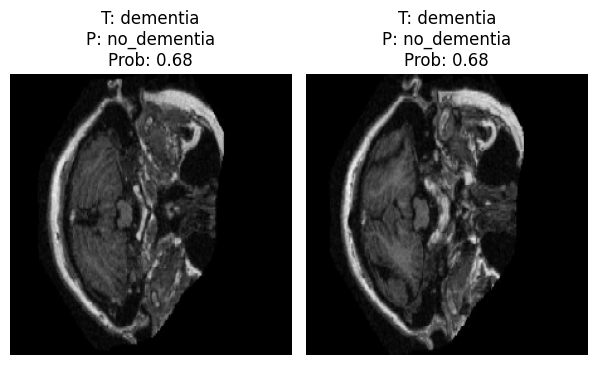

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Tomamos un batch del generador de test
test_gen.reset()
x_batch, y_batch = next(test_gen)

# Predicciones del modelo para ese batch
y_prob_batch = model.predict(x_batch).ravel()
y_pred_batch = (y_prob_batch >= 0.5).astype(int)

# Diccionario id -> nombre de clase
class_indices = test_gen.class_indices          # p.ej. {'no_dementia': 0, 'dementia': 1}
inv_class_indices = {v: k for k, v in class_indices.items()}

n_imgs = min(8, x_batch.shape[0])

plt.figure(figsize=(12, 8))
for i in range(n_imgs):
    plt.subplot(2, 4, i + 1)

    # Deshacer parcialmente el preprocess_input de VGG16 para visualizar
    img = x_batch[i].copy()
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 123.68
    img = np.clip(img / 255.0, 0, 1)

    plt.imshow(img)

    true_id = int(y_batch[i])
    pred_id = int(y_pred_batch[i])

    true_label = inv_class_indices.get(true_id, f"clase {true_id}")
    pred_label = inv_class_indices.get(pred_id, f"clase {pred_id}")

    plt.title(f"T: {true_label}\nP: {pred_label}\nProb: {y_prob_batch[i]:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()
